<a href="https://colab.research.google.com/github/nickteim/typedef/blob/mashine_learning/closer_versionv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/alinstein/Depth_estimation

https://github.com/FangGet/tf-monodepth2 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!git clone https://github.com/alinstein/Depth_estimation.git

Cloning into 'Depth_estimation'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 132 (delta 34), reused 74 (delta 16), pack-reused 40
Receiving objects: 100% (132/132), 140.28 MiB | 35.79 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
PATH = '/content/drive/My Drive/kaggle/Mobilenet/6.pth'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        #interpolate x from x.size to larger size(concat_with.shape=(C,H,W))
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=2208, decoder_width = 0.25):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)

        self.up1 = UpSample(skip_input=features//1 + 384, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 192, output_features=features//4)
#         self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//8)
        self.up3 = UpSample(skip_input=features//4 +  96, output_features=features//16)
        self.up4 = UpSample(skip_input=features//8 +  96, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[11]
        x_d0 = self.conv2(x_block4)
        #15x20 to 15x20
        x_d1 = self.up1(x_d0, x_block3)
        #15x20 to 30x40
        x_d2 = self.up2(x_d1, x_block2)
        #30x40 to 60x80
        x_d3 = self.up3(x_d2, x_block1)
        #60x80 to 120x160
#         x_d4 = self.up4(x_d3, x_block0)
        #120x160 to 240x320
        return self.conv3(x_d3)
       # return self.conv3(x_d4)

#Encoder uses the densenet_161 pretrained model
#following encoder encodes the image and store the features output from each output of layer
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.densenet161( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [ ]:
model = TheModelClass()
model.load_state_dict(torch.load(PATH),strict=False)
model.eval()

TheModelClass(
  (encoder): Encoder(
    (original_model): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _Den

In [ ]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2

In [ ]:
img = '/content/street2.PNG'

# Upload video

In [ ]:
# !pip install pytube3

In [1]:
!pip install git+https://github.com/nficano/pytube

  Cloning https://github.com/nficano/pytube to /tmp/pip-req-build-ha5wb1j_
  Running command git clone -q https://github.com/nficano/pytube /tmp/pip-req-build-ha5wb1j_
  Created wheel for pytube: filename=pytube-9.7.0-cp36-none-any.whl size=39341 sha256=1a8d878664e207c025fdc1086e3b4e06bf891684bec5006946ce3f7060bcf0a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-8tu8lmir/wheels/44/da/40/3b5e03abe33a91895343814fb44b309512375408f4a909555b
Successfully built pytube


In [2]:
from pytube import YouTube
from moviepy.editor import *
 
# download a file from youtube
youtube_link = 'https://www.youtube.com/watch?v=92U11ya1xuQ'
w = YouTube(youtube_link).streams.first()
w.download(output_path="/content/")

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3866624/45929032 bytes (8.4%)8077312/45929032 bytes (17.6%)12345344/45929032 bytes (26.9%)16654336/45929032 bytes (36.3%)20881408/45929032 bytes (45.5%)25116672/45929032 bytes (54.7%)29245440/45929032 bytes (63.7%)33447936/45929032 bytes (72.8%)37740544/45929032 bytes (82.2%)41975808/45929032 bytes (91.4%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


'/content/28 WAYS TO PEEL AND CUT FRUITS LIKE A PRO.mp4'

In [ ]:
# from google.colab import files
# files.download('/content/test_vid/downscaled2/')

# Video

In [ ]:
!cat '/content/drive/My Drive/kaggle/Depth_estimation/UtilityTest.py'

import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,os.listdir(self.root_dir)[idx])
        image = (Image.open(img_name))

        sample1={'image': image}

        if self.transform:  sample1 = self.transform({'image': image})
        return sample1
    
    

class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test

In [ ]:
!cat '/content/drive/My Drive/kaggle/Depth_estimation/Mobile_model.py'

import torch
import torch.nn as nn
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1280, decoder_width = .6):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/kaggle/Depth_estimation')

In [ ]:
import cv2
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import imageio
import random            
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# from UtilityTest import DepthDataset
# from UtilityTest import ToTensor

In [ ]:
Location_video='/content/28 WAYS TO PEEL AND CUT FRUITS LIKE A PRO.mp4'

In [ ]:
# import shutil
# shutil.rmtree('/content/test_vid/new_model')

In [ ]:
# for root, dirs, files in os.walk('/content/test_vid/Frames'):
#     for i,f in enumerate(files):
#         absname = os.path.join(root, f)
#         newname = os.path.join(root, 'bear'+'_'+str(i))
#         os.rename(absname, newname)

In [ ]:
# import cv2
# import os
# os.mkdir('/content/test_vid/')
# os.mkdir('/content/test_vid/Frames/')

# count=1
# vidcap = cv2.VideoCapture(Location_video)
# def getFrame(sec):
#     vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
#     hasFrames,image = vidcap.read()
#     if hasFrames:
#         cv2.imwrite("/content/test_vid/Frames/%d.jpg" % count, image) # Save frame as JPG file
#         hasFrames,image = vidcap.read()
#     return hasFrames, image
# sec = 0
# frameRate = 0.5 # Change this number to 1 for each 1 second

# success = getFrame(sec)
# while success:
#     count = count + 1
#     sec = sec + frameRate
#     sec = round(sec, 2)
#     success, image = getFrame(sec)
#     print('Read a new frame: ', success)

In [ ]:
# rename 's/\d+/sprintf("%02d", $&)/e'

In [ ]:
# os.mkdir('/content/test_vid/')
# os.mkdir('/content/test_vid/Frames/')
# #converting video into frames
# vidcap = cv2.VideoCapture(Location_video)
# success,image = vidcap.read()
# count = 7
# # for i in range(1):
# if success == True:
#   cv2.imwrite("/content/test_vid/Frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   count += 1
  # i += 1

In [ ]:
os.mkdir('/content/test_vid/')
os.mkdir('/content/test_vid/Frames/')
# converting video into frames
vidcap = cv2.VideoCapture(Location_video)
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/test_vid/Frames/%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame:%d, ',count, success)
  count += 1

Read a new frame:%d,  0 True
Read a new frame:%d,  1 True
Read a new frame:%d,  2 True
Read a new frame:%d,  3 True
Read a new frame:%d,  4 True
Read a new frame:%d,  5 True
Read a new frame:%d,  6 True
Read a new frame:%d,  7 True
Read a new frame:%d,  8 True
Read a new frame:%d,  9 True
Read a new frame:%d,  10 True
Read a new frame:%d,  11 True
Read a new frame:%d,  12 True
Read a new frame:%d,  13 True
Read a new frame:%d,  14 True
Read a new frame:%d,  15 True
Read a new frame:%d,  16 True
Read a new frame:%d,  17 True
Read a new frame:%d,  18 True
Read a new frame:%d,  19 True
Read a new frame:%d,  20 True
Read a new frame:%d,  21 True
Read a new frame:%d,  22 True
Read a new frame:%d,  23 True
Read a new frame:%d,  24 True
Read a new frame:%d,  25 True
Read a new frame:%d,  26 True
Read a new frame:%d,  27 True
Read a new frame:%d,  28 True
Read a new frame:%d,  29 True
Read a new frame:%d,  30 True
Read a new frame:%d,  31 True
Read a new frame:%d,  32 True
Read a new frame:%d,

KeyboardInterrupt: ignored

In [ ]:
os.mkdir('/content/test_vid/depth_frames/')
os.mkdir('/content/test_vid/new_frames')

In [ ]:
import shutil
import os

sourcedir = "/content/test_vid/Frames"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

In [ ]:
# import shutil
# import os

# sourcedir = "/content/test_vid/Frames"; number_ofdigits = 5; extensions = (".jpg", ".jpeg")

# files = os.listdir(sourcedir)
# for item in files:
#     if item.endswith(extensions):
#         name = item.split("."); zeros = number_ofdigits-len(name[0])
#         newname = str(zeros*"0")+name[0]+"."+name[1]
#         shutil.move(sourcedir+"/"+item, sourcedir+"/"+newname)

In [ ]:
import os
# path = '/content/test_vid/Frames'
# for filename in os.listdir(path):
#     prefix, num = filename[:-4].split('_')
#     num = num.zfill(4)
#     new_filename = prefix + "_" + num + ".png"
#     os.rename(os.path.join(path, filename), os.path.join(path, new_filename))

In [ ]:
# Tcl().call('lsort', '-dict', path)

In [ ]:
# import shutil 
# shutil.rmtree('/content/test_vid/gray')

In [ ]:
#location of video frames
loc_img='/content/test_vid/Frames/'

#ploting few sample frames
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size)


    plt.imshow(sample['image'])
    plt.figure()


    if i == 2:
        plt.show()
        break

In [ ]:
def setter():
  path1 = '/content/test_vid/Frames' + '/'
  data = os.listdir(path1)
  sorted_data = sorted(data)
  print(sorted_data[0])

In [ ]:
def move_image():
  path1 = '/content/test_vid/Frames' 
  data = os.listdir(path1)
  sorted_data = sorted(data)
  c = 'Frames/'
  #move images to training folder
  from_folder = '/content/test_vid/' + c + sorted_data[0] #always index zero since we removes the previus file 
  to_folder =  '/content/test_vid/new_frames'
  new_path = shutil.copy(from_folder, to_folder)
  print('2: ' + new_path)
  os.remove(from_folder)



In [ ]:
loc_img='/content/test_vid/new_frames'
depth_dataset = DepthDataset(root_dir=loc_img,transform=transforms.Compose([ToTensor()]))

# depth_dataset
batch_size=1
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)


In [ ]:
def convert_to_tensor():
  loc_img='/content/test_vid/new_frames'
  depth_dataset = DepthDataset(root_dir=loc_img,transform=transforms.Compose([ToTensor()]))

  # depth_dataset
  batch_size=1
  train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
  # train_loader
  dataiter = iter(train_loader)


  images = dataiter.next()
  



### Start new model

https://pytorch.org/hub/intelisl_midas_v2/

In [ ]:
assert False

In [ ]:
# os.mkdir('/content/test_vid/new_model')
# os.mkdir('/content/drive/My Drive/kaggle/new_model')

In [ ]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

# url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
# urllib.request.urlretrieve(url, filename)

In [ ]:
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/facebookresearch/WSL-Images/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2/model-f46da743.pt" to /root/.cache/torch/hub/checkpoints/model-f46da743.pt


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.default_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
# filename= '/content/test_vid/Frames/0000.jpg'

In [ ]:
os.mkdir('/content/test_vid/new_model')

In [ ]:
def setter_inew_model():
  from matplotlib import pyplot as plt
  from PIL import Image
  import cv2
  from skimage import io

  path1_depth = '/content/test_vid/Frames'
  data_depth = os.listdir(path1_depth)
  ordedered_list = sorted(data_depth)
  ordedered_list = ordedered_list


In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import cv2
from skimage import io

path1_depth = '/content/test_vid/Frames'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
ordedered_list = ordedered_list[500:]

# count = 0
def images(number):
  for e in ordedered_list[:1]:
    c = e
    input = '/content/test_vid/Frames/'+c
    print(input)
    img_ori = io.imread(input)
    # # print(input)(imgUMat),
    img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()
      
    output = prediction.cpu().numpy()
    plt.imshow(output)
    plt.axis('off')
    # number = 'f0' +'1'+ '.png'
    out = "/content/food%d.png" % number
    plt.savefig(out, bbox_inches='tight')
   

    



In [ ]:
def move_image_new_model(number):  
  for e in ordedered_list[:1]:
    out = "/content/food%d.png" % number
    
    im = Image.open(out)
    im.mode
    'P'
    im = im.convert('RGB')
    im.mode
    'RGB'
    out1 = "/content/test_vid/new_model/%d.jpg" % number
    im.save(out1, quality=95)
    os.remove(out)

In [ ]:
path1_depth = '/content/test_vid/Frames'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
# ordedered_list =


# path1_depth2 = '/content'
# data_depth2 = os.listdir(path1_depth2)
# ordedered_list2 = sorted(data_depth2)
# print(ordedered_list2[5])

def remove(number):
  for i in  ordedered_list[:1]:
    from_folder = '/content/test_vid/Frames/' + i
    print("Removed: ", from_folder)
    os.remove(from_folder)
    
  # for e in ordedered_list2[:1]:
  #   from_folder2 = '/content/' + i
  #   print("Removed: ", from_folder2)
  #   os.remove(from_folder2)

In [ ]:
setter_inew_model()

In [ ]:
# number

/content/test_vid/Frames/0536.jpg
Removed:  /content/test_vid/Frames/0536.jpg
/content/test_vid/Frames/0537.jpg
Removed:  /content/test_vid/Frames/0537.jpg
/content/test_vid/Frames/0538.jpg
Removed:  /content/test_vid/Frames/0538.jpg
/content/test_vid/Frames/0539.jpg
Removed:  /content/test_vid/Frames/0539.jpg
/content/test_vid/Frames/0540.jpg
Removed:  /content/test_vid/Frames/0540.jpg
/content/test_vid/Frames/0541.jpg
Removed:  /content/test_vid/Frames/0541.jpg
/content/test_vid/Frames/0542.jpg
Removed:  /content/test_vid/Frames/0542.jpg
/content/test_vid/Frames/0543.jpg
Removed:  /content/test_vid/Frames/0543.jpg
/content/test_vid/Frames/0544.jpg
Removed:  /content/test_vid/Frames/0544.jpg
/content/test_vid/Frames/0545.jpg
Removed:  /content/test_vid/Frames/0545.jpg
/content/test_vid/Frames/0546.jpg
Removed:  /content/test_vid/Frames/0546.jpg
/content/test_vid/Frames/0547.jpg
Removed:  /content/test_vid/Frames/0547.jpg
/content/test_vid/Frames/0548.jpg
Removed:  /content/test_vid/Fr

KeyboardInterrupt: ignored

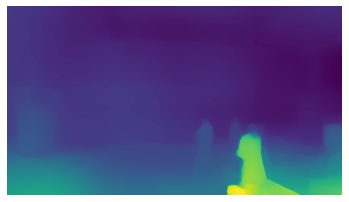

In [ ]:
number=0

# for i in range(1):
for i in range(1000):
  setter_inew_model()
  from matplotlib import pyplot as plt
  from PIL import Image
  import cv2
  from skimage import io

  path1_depth = '/content/test_vid/Frames'
  data_depth = os.listdir(path1_depth)
  ordedered_list = sorted(data_depth)
  ordedered_list = ordedered_list[500:]

  # count = 0

  for e in ordedered_list[:1]:
    c = e
    input = '/content/test_vid/Frames/'+c
    print(input)
    img_ori = io.imread(input)
    # # print(input)(imgUMat),
    img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()
      
    output = prediction.cpu().numpy()
    plt.imshow(output)
    plt.axis('off')
    # number = 'f0' +'1'+ '.png'
    out = "/content/food%d.png" % number
    plt.savefig(out, bbox_inches='tight')
      

      
    
  move_image_new_model(number)
  remove(number)
  number += 1

  # for i in range(1):
  #  

  # for i in range(1):
    # 

   


In [ ]:
import shutil
import os

sourcedir = "/content/test_vid/new_model"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

In [ ]:
filename = '/content/test_vid/Frames/0079.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [ ]:
for e in ordedered_list[:1]:
  c = e
  print(c)

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    
output = prediction.cpu().numpy()

In [ ]:
plt.imshow(output)
# plt.show()

In [ ]:
assert False

### End new model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
from Mobile_model import Model
model = Model().cuda()
model = nn.DataParallel(model)
#loading the the trained model
model.load_state_dict(torch.load('/content/drive/My Drive/Kopi af 6.pth'))
model.eval()

ModuleNotFoundError: ignored

In [ ]:

def make_new_image(number=0):
  #generating the depth image of frames
  # number = 2
  import matplotlib.cm as cm
  for i,sample_batched1  in enumerate (train_loader):
      image1 = sample_batched1['image']
      outtt=model(image1 )
      x=outtt.detach().cpu().numpy()
      x.shape
      x=x.reshape(240,320)
      img=x
      scale_percent = 200 # percent of original size
      width = int(img.shape[1] * scale_percent / 100)
      height = int(img.shape[0] * scale_percent / 100)
      dim = (width, height)
      # resize image
      resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
      plt.imsave('/content/test_vid/depth_frames/geeks%d.jpg' %number, resized, cmap='inferno')
  # number += 1



In [ ]:
# print(number)

In [ ]:
def remove_old_image():
  #removes previus file from ols older 
  path1_depth = '/content/test_vid/new_frames' + '/'
  data_depth = os.listdir(path1_depth)
  sorted_depth_data = sorted(data_depth)
  # print(sorted_depth_data)
  # #move images to training folder
  from_folder = '/content/test_vid/new_frames'+ '/' + sorted_depth_data[0] #always index zero since we removes the previus file 
  os.remove(from_folder)
  print('removed')


In [ ]:
for i in range(len(os.listdir('/content/test_vid/Frames'))):
  setter()
  move_image()
  convert_to_tensor() 
  make_new_image(number=i)
  remove_old_image()

In [ ]:
import shutil
import os

sourcedir = "/content/test_vid/depth_frames"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

In [ ]:
# from tkinter import *

### Gray scale image 

In [ ]:
os.mkdir('/content/test_vid/gray')

In [ ]:
import cv2
path1_depth = '/content/test_vid/new_model/'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
ordedered_list = ordedered_list[1:-1]
# print(ordedered_list)

count = 0
for e in ordedered_list:
  c = e
  input = '/content/test_vid/new_model/'+c
  img = cv2.imread(input, cv2.IMREAD_UNCHANGED)
 
  grey_scaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  cv2.imwrite("/content/test_vid/gray/gray%d.jpg" % count, grey_scaled)     # save frame as JPEG file      
  print('Read a new frame:%d, ',count)
  count += 1

Read a new frame:%d,  0
Read a new frame:%d,  1
Read a new frame:%d,  2
Read a new frame:%d,  3
Read a new frame:%d,  4
Read a new frame:%d,  5
Read a new frame:%d,  6
Read a new frame:%d,  7
Read a new frame:%d,  8
Read a new frame:%d,  9
Read a new frame:%d,  10
Read a new frame:%d,  11
Read a new frame:%d,  12
Read a new frame:%d,  13
Read a new frame:%d,  14
Read a new frame:%d,  15
Read a new frame:%d,  16
Read a new frame:%d,  17
Read a new frame:%d,  18
Read a new frame:%d,  19
Read a new frame:%d,  20
Read a new frame:%d,  21
Read a new frame:%d,  22
Read a new frame:%d,  23
Read a new frame:%d,  24
Read a new frame:%d,  25
Read a new frame:%d,  26
Read a new frame:%d,  27
Read a new frame:%d,  28
Read a new frame:%d,  29
Read a new frame:%d,  30
Read a new frame:%d,  31
Read a new frame:%d,  32
Read a new frame:%d,  33
Read a new frame:%d,  34
Read a new frame:%d,  35
Read a new frame:%d,  36
Read a new frame:%d,  37
Read a new frame:%d,  38
Read a new frame:%d,  39
Read a new

In [ ]:
import shutil
import os

sourcedir = "/content/test_vid/gray"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

### Convert to video

In [ ]:
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    #files.sort(key = lambda x: int(x[5:-4]))
    files = sorted(files)
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [ ]:
pathIn= '/content/test_vid/gray/'
pathOut = '/content/video1.mp4'
#enter the correct frame rates
fps = 30
convert_frames_to_video(pathIn, pathOut, fps)

/content/test_vid/gray/00gray0.jpg
/content/test_vid/gray/00gray1.jpg
/content/test_vid/gray/00gray2.jpg
/content/test_vid/gray/00gray3.jpg
/content/test_vid/gray/00gray4.jpg
/content/test_vid/gray/00gray5.jpg
/content/test_vid/gray/00gray6.jpg
/content/test_vid/gray/00gray7.jpg
/content/test_vid/gray/00gray8.jpg
/content/test_vid/gray/00gray9.jpg
/content/test_vid/gray/0gray10.jpg
/content/test_vid/gray/0gray11.jpg
/content/test_vid/gray/0gray12.jpg
/content/test_vid/gray/0gray13.jpg
/content/test_vid/gray/0gray14.jpg
/content/test_vid/gray/0gray15.jpg
/content/test_vid/gray/0gray16.jpg
/content/test_vid/gray/0gray17.jpg
/content/test_vid/gray/0gray18.jpg
/content/test_vid/gray/0gray19.jpg
/content/test_vid/gray/0gray20.jpg
/content/test_vid/gray/0gray21.jpg
/content/test_vid/gray/0gray22.jpg
/content/test_vid/gray/0gray23.jpg
/content/test_vid/gray/0gray24.jpg
/content/test_vid/gray/0gray25.jpg
/content/test_vid/gray/0gray26.jpg
/content/test_vid/gray/0gray27.jpg
/content/test_vid/gr

In [ ]:
from google.colab import files
files.download('/content/video1.mp4') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
assert False

# Downscaling images

In [ ]:
# import shutil
# shutil.rmtree('/content/test_vid/downscaled2')

In [ ]:
os.mkdir('/content/drive/My Drive/kaggle/test_vid/downscaled2/')


In [ ]:
import cv2
path1_depth = '/content/drive/My Drive/kaggle/test_vid/gray/'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
# ordedered_list = ordedered_list[:1000]

count = 0
for e in ordedered_list:
  c = e
  input = '/content/drive/My Drive/kaggle/test_vid/gray/'+c
  img = cv2.imread(input, cv2.IMREAD_UNCHANGED)
  # print(input)
  print('Original Dimensions : ',img.shape)
  
  # scale_percent = 60 # percent of original size
  width = int(64)
  height = int(64)
  dim = (width, height)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  
  print('Resized Dimensions : ',resized.shape)
  
  # cv2.imshow("Resized image", resized)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
 

  cv2.imwrite("/content/drive/My Drive/kaggle/test_vid/downscaled2/%d.jpg" % count, resized)     # save frame as JPEG file      
  print('Read a new frame:%d, ',count)
  count += 1



In [ ]:
#zero padding file names
sourcedir = "/content/drive/My Drive/kaggle/test_vid/downscaled2"; extensions = (".jpg", ".jpeg")
files = [(f, f[f.rfind("."):], f[:f.rfind(".")]) for f in os.listdir(sourcedir)if f.endswith(extensions)]
maxlen = len(max([f[2] for f in files], key = len))

for item in files:
    zeros = maxlen-len(item[2])
    shutil.move(sourcedir+"/"+item[0], sourcedir+"/"+str(zeros*"0")+item[0])

In [ ]:
pathIn= '/content/drive/My Drive/kaggle/test_vid/downscaled2/'
pathOut = '/content/video1_downscale.mp4'
#enter the correct frame rates
fps = 30
convert_frames_to_video(pathIn, pathOut, fps)

In [ ]:
from google.colab import files
files.download('/content/test_vid/video1.mp4') 

In [ ]:
path1 = os.listdir 

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(resized)

In [ ]:
img = cv2_imshow(resized)

In [ ]:
img_src = cv2.imread('/content/test_vid/downscaled2/000.jpg',0)
img_src.shape

In [ ]:
# import numpy as np
# import cv2

# img = cv2.imread('/content/test_vid/downscaled/python_grey.png') # Read in the image and convert to grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
# coords = cv2.findNonZero(gray) # Find all non-zero points (text)
# x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
# rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
# # cv2.imshow("Cropped", rect) # Show it #dosent currently work in colab use code above to show image from cv2
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imwrite("rect.png", rect) # Save the image

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(rect)

In [ ]:
# print('Resized Dimensions : ',rect.shape)

In [ ]:

import time


In [ ]:
!zip -r /content/downscaled.zip /content/downscaled2 #only work if it is in content not work in drive

In [ ]:
files.download("/content/downscaled.zip")

In [ ]:
from google.colab import files
# for i in range(1):
path1_depth = '/content/test_vid/downscaled2'
data_depth = os.listdir(path1_depth)
ordedered_list = sorted(data_depth)
def download():
  for e in ordedered_list:
    files.download('/content/test_vid/gray')
    print("downloaded: ", e)
    # print("Sleep for 10s")
    # time.sleep(10)
  


In [ ]:
print(str(path1_depth) + str((ordedered_list[:1])).replace("'",'').replace('[','').replace(']',''))

In [ ]:
download()


In [ ]:
img = '/content/test_vid/downscaled2/000.jpg'

In [ ]:
assert False

# convert to gif

In [ ]:

#converting the frames to gif

filenames='/content/test_vid/depth_frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(float(x[5:-4])))
files
images = []
for i,filename in enumerate(files):
    if i%10==0:
        images.append(imageio.imread(os.path.join('/content/test_vid/depth_frames/',filename)))
        print(filename)
imageio.mimsave('/content/test_vid/movie_depth.gif', images)

In [ ]:

from skimage import transform,io
filenames='/content/test_vid/Frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(float(x[5:-4])))
files
images = []
for i,filename in enumerate(files):
    if i%10==0:
       

            # resize to 28x28
        grey=(imageio.imread(os.path.join('/content/test_vid/Frames/',filename)))
        image = transform.resize(grey, (480,640), mode='symmetric', preserve_range=True)
        images.append(image)
        print(filename)
imageio.mimsave('/content/test_vid/movie_real.gif', images)